In [27]:
# Profiling Scanpy for 68k PBMC cells of Zheng et al., Nat. Comm. (2017)
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = '/home/gunnar/Desktop/68k_pbmcs_test_data_set/test.h5ad'

scanpy==1.3.6 anndata==0.6.15 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [28]:
sc.logging.print_memory_usage()

Memory usage: current 2.54 GB, difference +1.72 GB


In [29]:
# Only use the first n cells, set to None if you want all cells.
use_first_n_observations = None

In [30]:
# Load the data. This takes a long time only when first reading the raw data from the .mtx text file. 
# It's very fast through reading from the ./cache/ directory after that (change this using sc.settings.cachedir).
# If you want to use %%time the whole cell has to be empty of comments - see below:

In [31]:
%%time
path = '/home/gunnar/Desktop/68k_pbmcs_test_data_set/filtered_matrices_mex/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 2.14 s, sys: 209 ms, total: 2.35 s
Wall time: 2.34 s


In [32]:
adata.var_names_make_unique()
adata.obs['bulk_labels'] = pd.read_csv('/home/gunnar/Desktop/68k_pbmcs_test_data_set/zheng17_bulk_lables.txt',
                                       header=None)[0].values

In [33]:
# Reduce the number of observations for scaling information.
adata = adata[:use_first_n_observations]
# Save the logarithmized raw data for differential expression testing and plotting.
sc.pp.log1p(adata, copy=True).write('./write/zheng17_raw.h5ad')
adata

... storing 'bulk_labels' as categorical


View of AnnData object with n_obs × n_vars = 68579 × 32738 
    obs: 'bulk_labels'

In [34]:
# Per-cell normalize the data matrix X and identify highly-variable genes.

In [35]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 1.69 GB, difference -0.84 GB
CPU times: user 1.8 s, sys: 905 ms, total: 2.7 s
Wall time: 2.7 s


In [50]:
sc.pp.recipe_zheng17(adata)

AssertionError: Don’t call _normalize_index with non-categorical/string names

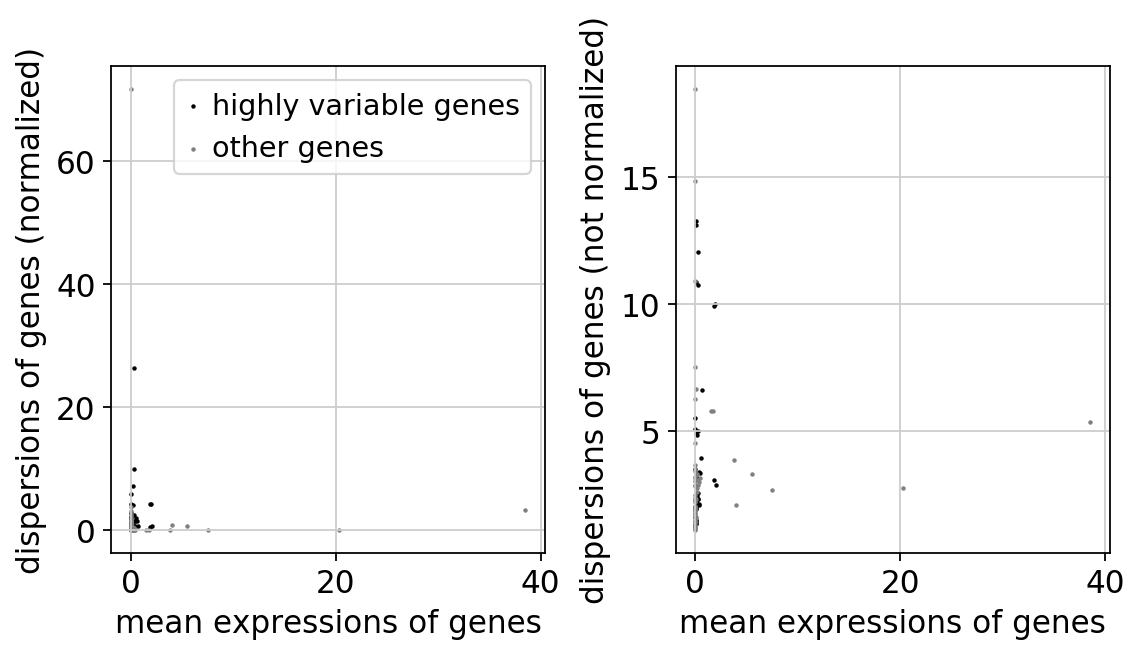

In [52]:
# Plot the dispersion relation. Use a logarithmic scale as the data is not yet logarithmized.

sc.pl.filter_genes_dispersion(filter_result, log=True)